In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



In [12]:
# Load the data
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')



In [13]:
print(train_df.head())

   seq_id                                   protein_sequence   pH  \
0       0  AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...  7.0   
1       1  AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...  7.0   
2       2  AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...  7.0   
3       3  AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...  7.0   
4       4  AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...  7.0   

                         data_source    tm  
0  doi.org/10.1038/s41592-020-0801-4  75.7  
1  doi.org/10.1038/s41592-020-0801-4  50.5  
2  doi.org/10.1038/s41592-020-0801-4  40.5  
3  doi.org/10.1038/s41592-020-0801-4  47.2  
4  doi.org/10.1038/s41592-020-0801-4  49.5  


In [14]:
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB
None
             seq_id            pH            tm
count  31390.000000  31104.000000  31390.000000
mean   15694.500000      6.892339     49.147337
std     9061.656811      1.612225     14.010089
min        0.000000      1.990000     -1.000000
25%     7847.250000      7.000000     42.100000
50%    15694.500000      7.000000     48.000000
75%    23541.750000      7.000000     53.800000
max    31389.000000     64.900000    130.000000


In [15]:
# Check for missing values
missing_values = train_df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 seq_id                 0
protein_sequence       0
pH                   286
data_source         3347
tm                     0
dtype: int64


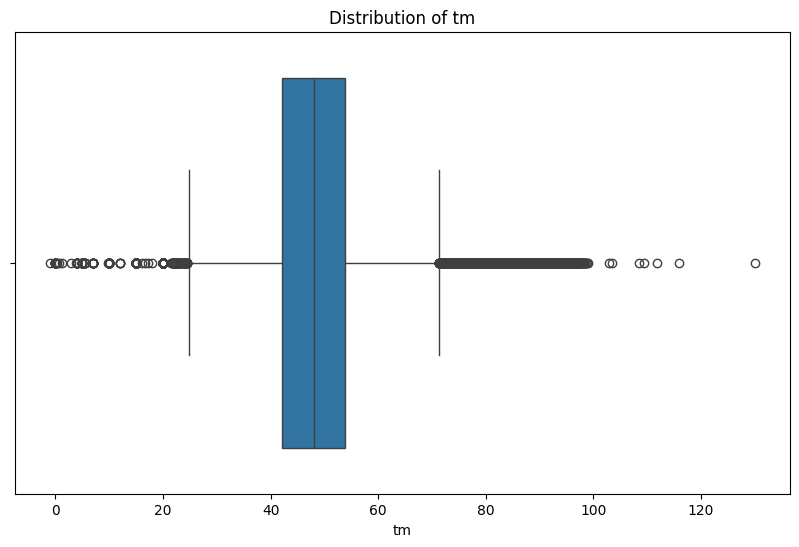

In [16]:
# boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['tm'])
plt.title('Distribution of tm')
plt.xlabel('tm')
plt.show()

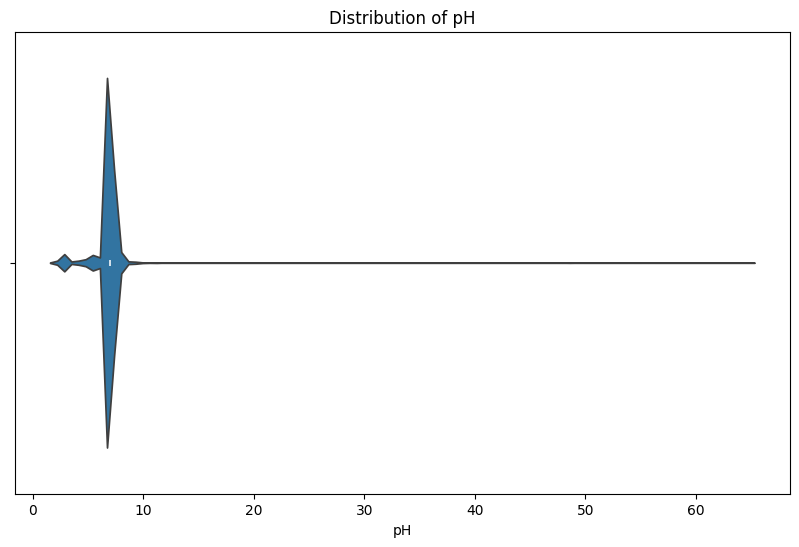

In [17]:
# violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x=train_df['pH'])
plt.title('Distribution of pH')
plt.xlabel('pH')
plt.show()

# Data preprocessing

In [18]:
# Fill missing values in 'pH' with the median value
train_df['pH'].fillna(train_df['pH'].median(), inplace=True)

In [19]:
# Drop data_source column
train_df.drop(columns=['data_source'], inplace=True)



In [20]:
# new features from sequence
train_df['sequence_length'] = train_df['protein_sequence'].apply(len)
train_df['num_unique_amino_acids'] = train_df['protein_sequence'].apply(lambda x: len(set(x)))

In [21]:
# Normalisation of numerical features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df[['pH', 'sequence_length', 'num_unique_amino_acids']] = scaler.fit_transform(train_df[['pH', 'sequence_length', 'num_unique_amino_acids']])

In [22]:
# train and validation split
from sklearn.model_selection import train_test_split

X = train_df.drop(columns=['seq_id', 'protein_sequence', 'tm'])
y = train_df['tm']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# check the split
print(X_train.shape, X_val.shape)

(25112, 3) (6278, 3)


# Model building

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [25]:
# Defination of the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['pH', 'sequence_length', 'num_unique_amino_acids'])
    ])

In [26]:
# Defining the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

In [27]:
# Trainning and evaluate every model
for model_name, model in models.items():
    # Create a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

In [29]:
  # Trainning the model
  pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['pH', 'sequence_length',
                                                   'num_unique_amino_acids'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [30]:
# model evaluation
y_pred = pipeline.predict(X_val)

In [32]:
# evaluation metrics
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)

print(f'{model_name} - RMSE: {rmse}, MAE: {mae}')

XGBoost - RMSE: 11.638329137342437, MAE: 8.221654054968743


# Inference

In [33]:
# Preprocessing
test_df['sequence_length'] = test_df['protein_sequence'].apply(len)
test_df['num_unique_amino_acids'] = test_df['protein_sequence'].apply(lambda x: len(set(x)))

In [34]:
# Handle missing values in 'pH' column
test_df['pH'] = test_df['pH'].fillna(train_df['pH'].median())

In [35]:
# Normalisation of the numerical features
test_df[['pH', 'sequence_length', 'num_unique_amino_acids']] = scaler.transform(test_df[['pH', 'sequence_length', 'num_unique_amino_acids']])

In [36]:
# features for the test set
X_test = test_df.drop(columns=['seq_id', 'protein_sequence'])

In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model, store predictions
model_predictions = {}
for model_name, model in models.items():
    #pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])

    # Training the model
    pipeline.fit(X_train, y_train)

    # Saving the trained pipeline
    models[model_name] = pipeline

    # Evaluate the model on validation set
    y_pred_val = pipeline.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred_val, squared=False)
    mae = mean_absolute_error(y_val, y_pred_val)

    print(f'{model_name} - RMSE: {rmse}, MAE: {mae}')

    # Saving validation predictions
    model_predictions[model_name] = pipeline.predict(X_test)

Linear Regression - RMSE: 13.755609981282237, MAE: 9.621076430920123
Random Forest - RMSE: 12.106945501279947, MAE: 8.5032488951062
XGBoost - RMSE: 11.638329137342437, MAE: 8.221654054968743


In [39]:
# Combine predictions from all models using mean
combined_predictions = np.mean(np.column_stack(list(model_predictions.values())), axis=1)

# submission file
submission_ensemble = pd.DataFrame({'seq_id': test_df['seq_id'], 'tm': combined_predictions})
submission_ensemble.to_csv('submission_ensemble.csv', index=False)
